In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
def remove_background(scan_long, mask_long):
    is_bg = mask_long == 1
    is_bg = is_bg.reshape(len(is_bg))
    return scan_long[is_bg,:]

In [4]:
def indices_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

In [2]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [3]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [4]:
def get_acquisition_scheme():
    bvals = np.loadtxt(
        config.data_folder2 + '/100206/bvals'
    ) * 1e-3
    # s/m^2
    gradient_directions = np.loadtxt(
        config.data_folder2 + '/100206/bvecs'
    ).T

    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [5]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 6))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        # theta = squash(theta_uns, 0, np.pi)
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        # phi = squash(phi_uns, -np.pi, np.pi)
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        # s0 = params[:, 5].unsqueeze(1)
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

## Trainig data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [3]:
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [4]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [5]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [6]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long)

In [37]:
# Error voxels
indices_beginning_0 = np.where(scan_100206_long_no_background[:, 0] == 0)[0]

In [39]:
len(indices_beginning_0)

814

In [6]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [7]:
len(indices_beginning_0_all)

2234299

In [8]:
mask_0 = np.where(mask_100206_long[:,0] == 0)[0]

In [9]:
len(mask_0)

2722094

In [10]:
mask_100206_long_pro = np.copy(mask_100206_long)

In [11]:
mask_100206_long_pro[indices_beginning_0_all] = 0

In [12]:
mask_0_pro = np.where(mask_100206_long_pro[:,0] == 0)[0]
print(len(mask_0_pro))

2722908


In [ ]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

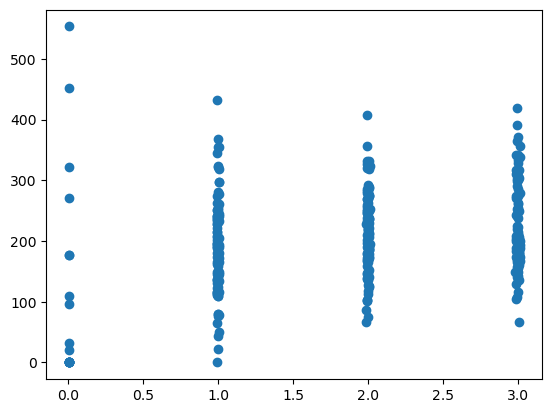

In [35]:
plt.plot(bvals, scan_100206_long_no_background[201834,:], "o")

In [51]:
normalized_scan_100206 = np.load('normalized_scan_100206.npy')

In [52]:
normalized_scan_100206

array([[1.30231222, 0.79474696, 0.5139521 , ..., 0.6643841 , 0.56590588,
        0.31567214],
       [1.11819184, 0.4604651 , 0.57350542, ..., 0.44744371, 0.67474822,
        0.35966567],
       [1.02967767, 0.47128865, 0.34843168, ..., 0.36720369, 0.55323395,
        0.29989738],
       ...,
       [0.93215207, 0.33621187, 0.17415006, ..., 0.26950286, 0.17028434,
        0.28959991],
       [0.94993517, 0.55332968, 0.43955593, ..., 0.30752529, 0.37428291,
        0.17693152],
       [0.99949699, 0.14943101, 0.15482027, ..., 0.2864064 , 0.37132859,
        0.30503306]])

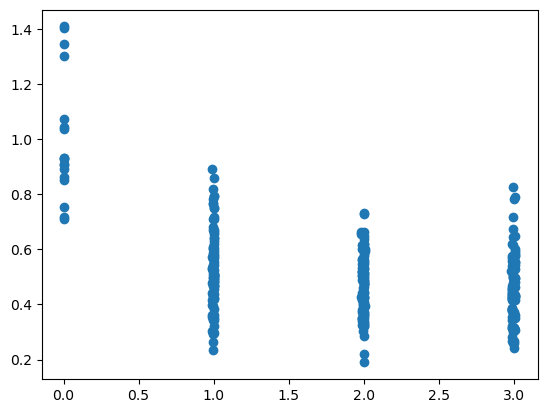

In [58]:
plt.plot(bvals, normalized_scan_100206[0,:], "o")

In [59]:
bvals

array([0.005, 1.   , 1.995, 3.005, 0.995, 2.995, 2.005, 0.99 , 1.99 ,
       3.   , 1.   , 1.985, 2.995, 1.005, 1.995, 2.995, 0.005, 0.995,
       2.   , 3.01 , 3.005, 0.995, 2.005, 0.995, 1.99 , 2.985, 1.005,
       2.   , 3.005, 0.995, 1.995, 2.99 , 0.005, 3.005, 0.995, 2.   ,
       0.99 , 1.99 , 2.99 , 0.995, 2.985, 1.995, 3.005, 0.995, 2.005,
       1.   , 1.99 , 2.995, 0.005, 1.005, 2.005, 2.995, 3.   , 1.005,
       1.985, 1.005, 2.985, 2.005, 0.995, 1.99 , 3.005, 1.   , 2.99 ,
       2.   , 0.005, 0.99 , 2.005, 2.995, 1.   , 2.005, 3.   , 0.995,
       2.005, 3.005, 1.005, 2.   , 3.01 , 0.99 , 2.005, 1.995, 0.005,
       1.   , 3.01 , 2.985, 1.005, 1.995, 3.   , 1.   , 2.005, 3.   ,
       0.99 , 2.005, 2.99 , 3.   , 1.   , 0.005, 2.99 , 0.995, 1.995,
       1.995, 1.005, 2.   , 2.995, 1.005, 2.01 , 2.995, 1.005, 2.   ,
       3.01 , 1.   , 2.005, 2.99 , 0.005, 0.99 , 2.985, 2.005, 1.   ,
       2.005, 2.985, 0.995, 2.005, 2.99 , 0.995, 2.005, 2.99 , 1.005,
       2.   , 3.005,

In [22]:
# normalized_scan_100206 = np.load('normalized_scan_100206.npy')

data_100206 = scan_100206_long_no_bg * 1e-3

In [23]:
data_100206

array([[0.58717719, 0.3583298 , 0.23172704, ..., 0.29955273, 0.25515158,
        0.14232799],
       [0.50774442, 0.20908629, 0.26041522, ..., 0.20317358, 0.30638718,
        0.16331566],
       [0.48708456, 0.22294106, 0.1648241 , ..., 0.17370412, 0.26170493,
        0.14186516],
       ...,
       [0.81258972, 0.29308771, 0.15181273, ..., 0.23493512, 0.14844284,
        0.25245442],
       [0.6111936 , 0.35601541, 0.28281274, ..., 0.19786349, 0.24081572,
        0.11383873],
       [0.88183643, 0.13184003, 0.13659486, ..., 0.2526907 , 0.32761588,
        0.26912463]])

In [14]:
bvals = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [21]:
n = np.loadtxt(config.data_folder2 + '/100206/bvecs').T
b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

In [24]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [25]:
batch_size = 128
num_batches = len(data_100206) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(data_100206.astype(np.float32)),
                               batch_size = batch_size, 
                               shuffle = True,
                               num_workers = 2,
                               drop_last = True)

In [26]:
loss_arr=[]
avg_loss_arr=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred,  volume_0_pred, volume_1_pred, s0_pred = net(X_batch)
        if i == 8 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
            print("s0_pred: ")
            print(s0_pred.shape)
            print(s0_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    avg_loss_arr.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.03it/s]


Loss: 486.4662619717419
Average Loss: 0.06656626463762205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.19it/s]


Loss: 332.4486370049417
Average Loss: 0.045491055966740794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.94it/s]


Loss: 296.83765311539173
Average Loss: 0.040618179134563726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.32it/s]


Loss: 284.92115348018706
Average Loss: 0.03898756889438794
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.19it/s]


Loss: 279.55134999379516
Average Loss: 0.038252784618745914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.52it/s]


Loss: 275.4848427083343
Average Loss: 0.03769633863004027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.46it/s]


Loss: 273.1084277164191
Average Loss: 0.03737115869135456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.53it/s]


Loss: 271.18119434453547
Average Loss: 0.03710744312322598
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.04it/s]


Loss: 270.0403154883534
Average Loss: 0.03695132943190386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.85it/s]


Loss: 269.0095241740346
Average Loss: 0.036810279717300845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  0%|▏                                                           | 23/7308 [00:02<07:02, 17.23it/s]

X_batch: 
torch.Size([128, 288])
tensor([[5.5601, 1.6396, 0.6627,  ..., 1.9702, 0.7679, 0.3467],
        [3.7954, 0.8858, 0.2727,  ..., 0.9524, 0.8924, 0.3056],
        [6.0419, 0.4309, 0.1807,  ..., 0.3244, 0.3642, 0.4594],
        ...,
        [4.1946, 1.8668, 1.7431,  ..., 2.1781, 0.9686, 0.7748],
        [4.2520, 2.3791, 0.9442,  ..., 1.8524, 1.5653, 0.5845],
        [3.8642, 2.4295, 1.2519,  ..., 1.7796, 1.2402, 0.4811]])
X_pred: 
torch.Size([128, 288])
tensor([[5.2856, 1.8549, 0.8145,  ..., 1.8467, 0.8980, 0.5586],
        [2.5940, 0.9559, 0.3964,  ..., 0.9621, 0.5888, 0.2544],
        [5.2565, 0.4789, 0.2006,  ..., 0.4750, 0.2329, 0.1872],
        ...,
        [3.9436, 1.9920, 1.2846,  ..., 2.0398, 1.0928, 0.9105],
        [4.4375, 2.1461, 1.0165,  ..., 2.1046, 1.3361, 0.8222],
        [3.9758, 2.1012, 1.1305,  ..., 2.0946, 1.1692, 0.7041]],
       grad_fn=<MulBackward0>)
s0_pred: 
torch.Size([128, 1])
tensor([[ 5.3164],
        [ 2.6094],
        [ 5.3326],
        [ 3.6444],
 

100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.73it/s]


Loss: 267.6215074043721
Average Loss: 0.03662034857750029
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.38it/s]


Loss: 266.9014907926321
Average Loss: 0.036521824136922836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.64it/s]


Loss: 266.21671722456813
Average Loss: 0.03642812222558404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.95it/s]


Loss: 265.29275157675147
Average Loss: 0.03630169014460201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.21it/s]


Loss: 264.9665751028806
Average Loss: 0.03625705734850583
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.71it/s]


Loss: 264.471361733973
Average Loss: 0.03618929416173687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.72it/s]


Loss: 264.18056609109044
Average Loss: 0.036149502749191355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.46it/s]


Loss: 263.6908291988075
Average Loss: 0.03608248894346024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.00it/s]


Loss: 263.880084361881
Average Loss: 0.0361083859280078
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.26it/s]


Loss: 263.12611251324415
Average Loss: 0.0360052151769628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.24it/s]


Loss: 262.6992085389793
Average Loss: 0.035946799197999355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.19it/s]


Loss: 262.40427236817777
Average Loss: 0.035906441210752295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.50it/s]


Loss: 262.40336168557405
Average Loss: 0.0359063165962745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.56it/s]


Loss: 262.3618167806417
Average Loss: 0.03590063174338282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.03it/s]


Loss: 261.86286027915776
Average Loss: 0.03583235636003801
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.30it/s]


Loss: 262.11783353611827
Average Loss: 0.03586724596827015
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.50it/s]


Loss: 261.62173503264785
Average Loss: 0.0357993616629239
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.78it/s]


Loss: 261.4009719192982
Average Loss: 0.03576915324566204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.29it/s]


Loss: 261.1942055746913
Average Loss: 0.035740860095059016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.55it/s]


Loss: 261.3045436721295
Average Loss: 0.035755958356886906
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.31it/s]


Loss: 261.37238284386694
Average Loss: 0.03576524122110932
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.99it/s]


Loss: 261.02894893474877
Average Loss: 0.0357182469806717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.23it/s]


Loss: 260.81038256175816
Average Loss: 0.035688339157328705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.43it/s]


Loss: 260.58095852844417
Average Loss: 0.03565694561144556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.88it/s]


Loss: 260.70552906766534
Average Loss: 0.03567399138856942
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.95it/s]


Loss: 260.40892365574837
Average Loss: 0.03563340498847131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.41it/s]


Loss: 260.47714827395976
Average Loss: 0.03564274059577993
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.89it/s]


Loss: 260.5472950991243
Average Loss: 0.03565233923085992
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.84it/s]


Loss: 260.23210064321756
Average Loss: 0.03560920917394876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.52it/s]


Loss: 260.04613123834133
Average Loss: 0.03558376180053932
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.98it/s]


Loss: 259.91714423149824
Average Loss: 0.03556611169013386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.61it/s]


Loss: 260.07193402945995
Average Loss: 0.03558729256013409
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.31it/s]


Loss: 259.8200521208346
Average Loss: 0.03555282596070534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.38it/s]


Loss: 260.0039920769632
Average Loss: 0.03557799563176836
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.81it/s]


Loss: 259.89561111852527
Average Loss: 0.03556316517768545
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.33it/s]


Loss: 259.9302347134799
Average Loss: 0.035567902943825926
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.48it/s]


Loss: 259.6554760802537
Average Loss: 0.03553030597704621
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.47it/s]


Loss: 259.70740369334817
Average Loss: 0.03553741156176083
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.52it/s]


Loss: 259.43734957277775
Average Loss: 0.03550045834329198
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.48it/s]


Loss: 259.5551480650902
Average Loss: 0.03551657745827726
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.42it/s]


Loss: 259.470996465534
Average Loss: 0.03550506246107471
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.76it/s]


Loss: 259.372729934752
Average Loss: 0.035491616028291186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.32it/s]


Loss: 259.3443762771785
Average Loss: 0.03548773621745738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.17it/s]


Loss: 259.3334176391363
Average Loss: 0.03548623667749539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.88it/s]


Loss: 259.2034697253257
Average Loss: 0.03546845508009383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.67it/s]


Loss: 258.82433268614113
Average Loss: 0.0354165753538781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.54it/s]


Loss: 259.10039248876274
Average Loss: 0.03545435036792046
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.85it/s]


Loss: 259.1602228805423
Average Loss: 0.03546253733997568
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.36it/s]


Loss: 258.85086786188185
Average Loss: 0.035420206330306764
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.30it/s]


Loss: 259.06430801562965
Average Loss: 0.0354494127005514
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.02it/s]


Loss: 258.8637104574591
Average Loss: 0.0354219636641296
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.75it/s]


Loss: 259.21590703725815
Average Loss: 0.03547015695638453
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.72it/s]


Loss: 258.87919293902814
Average Loss: 0.03542408223029942
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.52it/s]


Loss: 258.79404480569065
Average Loss: 0.03541243087105783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 132.89it/s]


Loss: 258.4577263724059
Average Loss: 0.03536641028631717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.89it/s]


Loss: 258.406663287431
Average Loss: 0.035359423000469486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.02it/s]


Loss: 258.52832656539977
Average Loss: 0.03537607095859329
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.39it/s]


Loss: 258.4299834948033
Average Loss: 0.035362614052381405
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.81it/s]


Loss: 258.80929813347757
Average Loss: 0.035414518080661955
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.56it/s]


Loss: 258.64940575137734
Average Loss: 0.03539263899170462
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.70it/s]


Loss: 258.9683426655829
Average Loss: 0.03543628115292596
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.98it/s]


Loss: 258.3981129415333
Average Loss: 0.0353582530023992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.65it/s]


Loss: 258.382006034255
Average Loss: 0.03535604899209839
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.48it/s]


Loss: 258.28613634593785
Average Loss: 0.03534293053447425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.26it/s]


Loss: 258.371011024341
Average Loss: 0.03535454447514245
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.00it/s]


Loss: 258.9697030354291
Average Loss: 0.03543646730096184
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.92it/s]


Loss: 258.3454047534615
Average Loss: 0.03535104060665866
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.23it/s]


Loss: 258.4373166486621
Average Loss: 0.03536361749434347
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 166.02it/s]


Loss: 258.47645348496735
Average Loss: 0.035368972835928755
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.19it/s]


Loss: 258.56141416728497
Average Loss: 0.03538059854505815
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.92it/s]


Loss: 258.857271367684
Average Loss: 0.035421082562627805
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.21it/s]


Loss: 258.852805159986
Average Loss: 0.03542047142309606
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.98it/s]


Loss: 258.701566811651
Average Loss: 0.035399776520477697
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.76it/s]


Loss: 258.31127460487187
Average Loss: 0.0353463703619146
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 10


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.56it/s]


Loss: 258.29294745996594
Average Loss: 0.03534386254241461
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 11


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.21it/s]


Loss: 258.40259492211044
Average Loss: 0.03535886630023405
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 12


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.31it/s]


Loss: 258.6034299097955
Average Loss: 0.03538634782564252
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 13


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.09it/s]


Loss: 258.3558370638639
Average Loss: 0.03535246812587081
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 14


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.90it/s]


Loss: 258.17558727040887
Average Loss: 0.03532780340317582
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 92.66it/s]


Loss: 258.1429960653186
Average Loss: 0.035323343741833414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.77it/s]


Loss: 258.65582276694477
Average Loss: 0.03539351707265254
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.24it/s]


Loss: 258.39464759640396
Average Loss: 0.03535777881724192
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.05it/s]


Loss: 258.1536940447986
Average Loss: 0.03532480761423079
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.27it/s]


Loss: 258.0143650174141
Average Loss: 0.035305742339547634
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.53it/s]


Loss: 258.24206367507577
Average Loss: 0.03533689979133495
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.06it/s]


Loss: 258.05801838077605
Average Loss: 0.035311715706181725
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.61it/s]


Loss: 258.3298184070736
Average Loss: 0.03534890782800679
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.25it/s]


Loss: 258.2246985230595
Average Loss: 0.03533452360742467
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.96it/s]


Loss: 257.969870261848
Average Loss: 0.03529965383988067
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.82it/s]


Loss: 258.02448450773954
Average Loss: 0.035307127053604205
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.10it/s]


Loss: 258.1853820141405
Average Loss: 0.035329143680095855
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.61it/s]


Loss: 258.00572054088116
Average Loss: 0.03530455946098538
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.16it/s]


Loss: 258.19412544742227
Average Loss: 0.0353303400995378
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.09it/s]


Loss: 258.159207964316
Average Loss: 0.03532556211881719
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.09it/s]


Loss: 257.7694509383291
Average Loss: 0.03527222919243693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.94it/s]


Loss: 258.14634620025754
Average Loss: 0.03532380216204947
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


 13%|███████▍                                                  | 940/7308 [00:06<00:47, 134.46it/s]


KeyboardInterrupt: 

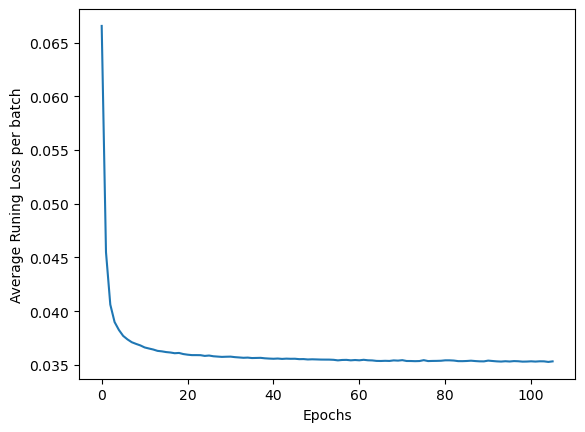

In [28]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

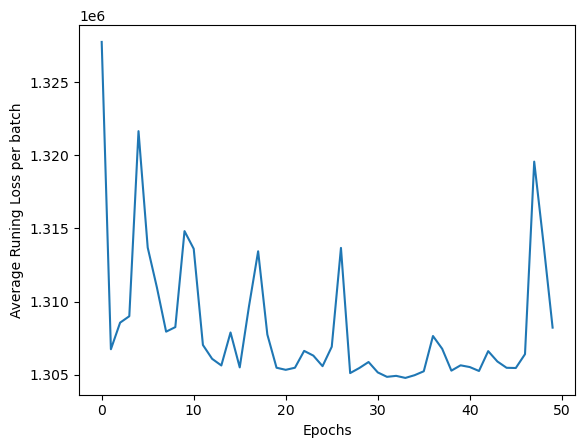

In [28]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

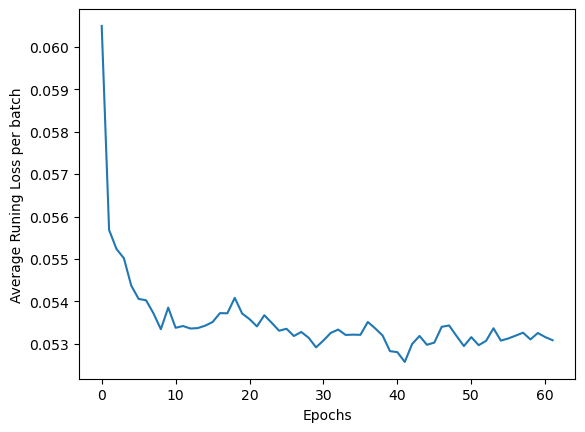

In [40]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [37]:
avg_loss_arr_small_lr = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/loss/avg_loss_for_333e_real_data.npy")

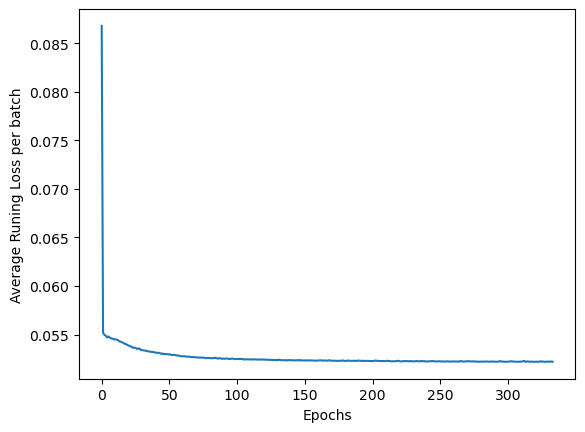

In [33]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(epoch_arr, avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [37]:
np.save("loss_for_333e_real_data.npy", loss_arr)
np.save("avg_loss_for_333e_real_data.npy", avg_loss_arr)

In [38]:
len(loss_arr)

334

In [29]:
net.load_state_dict(final_model)

<All keys matched successfully>

In [31]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=6, bias=True)
  )
)

In [30]:
torch.save(final_model, 'model_100206.pt')

In [36]:
data_100206[0:128, :]

array([[0.58717719, 0.3583298 , 0.23172704, ..., 0.29955273, 0.25515158,
        0.14232799],
       [0.50774442, 0.20908629, 0.26041522, ..., 0.20317358, 0.30638718,
        0.16331566],
       [0.48708456, 0.22294106, 0.1648241 , ..., 0.17370412, 0.26170493,
        0.14186516],
       ...,
       [0.91291248, 0.2155508 , 0.20319542, ..., 0.43916608, 0.19600398,
        0.25809616],
       [0.49877771, 0.35835001, 0.19056049, ..., 0.49013104, 0.15956306,
        0.27814551],
       [0.9379176 , 0.36414883, 0.30591693, ..., 0.2795788 , 0.24676875,
        0.36824832]])

In [37]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train, s0_pred_train = net(torch.from_numpy(data_100206[0:128, :].astype(np.float32)))

In [46]:
X_pred_train

tensor([[0.4589, 0.2381, 0.2205,  ..., 0.2328, 0.2229, 0.2259],
        [0.4592, 0.2418, 0.2022,  ..., 0.2406, 0.2259, 0.2089],
        [0.4803, 0.2320, 0.2163,  ..., 0.2272, 0.2150, 0.2204],
        ...,
        [0.8469, 0.2936, 0.2403,  ..., 0.2870, 0.2537, 0.2481],
        [0.6915, 0.2732, 0.2435,  ..., 0.2590, 0.2457, 0.2428],
        [1.0267, 0.3439, 0.2582,  ..., 0.3355, 0.2724, 0.2616]],
       grad_fn=<MulBackward0>)

In [60]:
net_test = BallStickNet(gradient_directions, b_values)


In [61]:
net_test.load_state_dict(torch.load('model_100206_61e.pt'))

<All keys matched successfully>

In [62]:
net_test.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=6, bias=True)
  )
)

In [95]:
X_pred_test, mu_cart_pred_test, lambda_par_pred_test, lambda_iso_pred_test,  volume_0_pred_test, volume_1_pred_test, s0_pred_test = net_test(torch.from_numpy(normalized_scan_100206.astype(np.float32)))



In [97]:
lambda_par_pred_test.shape

torch.Size([935439, 1])

In [99]:
mask_100206_long.shape

(3658350, 1)

In [100]:
np.sum(mask_100206_long)

936256.0

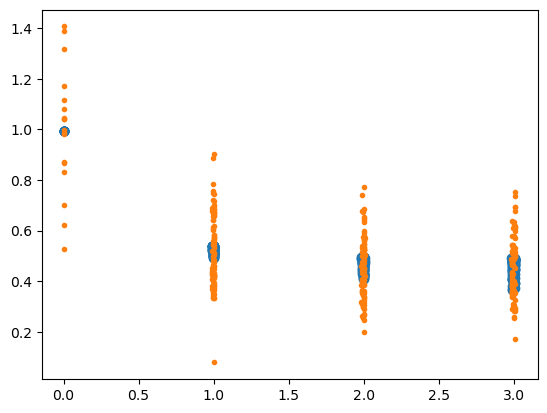

In [71]:
plt.plot(bvals, X_pred_test[1,:].detach().numpy(),  "o")
# plt.plot(X_pred_train[110,:].detach().numpy())
plt.plot(bvals,normalized_scan_100206[1,:], ".")

In [76]:
torch.min(lambda_par_pred_test)

tensor(0.1000, grad_fn=<MinBackward1>)

In [77]:
torch.max(lambda_par_pred_test)

tensor(0.1108, grad_fn=<MaxBackward1>)

In [110]:
bvals

array([0.005, 1.   , 1.995, 3.005, 0.995, 2.995, 2.005, 0.99 , 1.99 ,
       3.   , 1.   , 1.985, 2.995, 1.005, 1.995, 2.995, 0.005, 0.995,
       2.   , 3.01 , 3.005, 0.995, 2.005, 0.995, 1.99 , 2.985, 1.005,
       2.   , 3.005, 0.995, 1.995, 2.99 , 0.005, 3.005, 0.995, 2.   ,
       0.99 , 1.99 , 2.99 , 0.995, 2.985, 1.995, 3.005, 0.995, 2.005,
       1.   , 1.99 , 2.995, 0.005, 1.005, 2.005, 2.995, 3.   , 1.005,
       1.985, 1.005, 2.985, 2.005, 0.995, 1.99 , 3.005, 1.   , 2.99 ,
       2.   , 0.005, 0.99 , 2.005, 2.995, 1.   , 2.005, 3.   , 0.995,
       2.005, 3.005, 1.005, 2.   , 3.01 , 0.99 , 2.005, 1.995, 0.005,
       1.   , 3.01 , 2.985, 1.005, 1.995, 3.   , 1.   , 2.005, 3.   ,
       0.99 , 2.005, 2.99 , 3.   , 1.   , 0.005, 2.99 , 0.995, 1.995,
       1.995, 1.005, 2.   , 2.995, 1.005, 2.01 , 2.995, 1.005, 2.   ,
       3.01 , 1.   , 2.005, 2.99 , 0.005, 0.99 , 2.985, 2.005, 1.   ,
       2.005, 2.985, 0.995, 2.005, 2.99 , 0.995, 2.005, 2.99 , 1.005,
       2.   , 3.005,

**Reshape data and remove background voxels**

In [9]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [10]:
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [11]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [12]:
print(x, y, z, b)

145 174 145 288


In [13]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

In [14]:
mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [15]:
scan_100206_long_no_background = process_data.trim_background(scan_100206_long, mask_100206_long)

In [16]:
scan_100206_long_no_background.shape

(936256, 288)

In [17]:
# Ignore all strange data

def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

Sb_beginning_0 = find_rows_beginning_with_zero(scan_100206_long_no_background)

In [108]:
Sb_beginning_0

array([ 46080,  52289,  58710,  61649,  65169,  75865,  77984,  82681,
        88184,  96165,  96248,  98616, 104386, 104471, 105834, 106935,
       112589, 112845, 112930, 115186, 115316, 121280, 121706, 124612,
       127409, 130165, 130591, 132693, 133084, 133597, 137541, 139400,
       139753, 141694, 141918, 142846, 148444, 148806, 149505, 149838,
       151134, 151227, 151272, 152002, 152206, 152349, 152407, 154601,
       156409, 158104, 158288, 158471, 159177, 159511, 160888, 160932,
       161452, 161721, 161983, 161984, 162113, 162132, 162210, 167928,
       168205, 168297, 169004, 169341, 171395, 171798, 171931, 171948,
       172006, 172027, 172164, 172422, 172512, 172608, 172704, 178028,
       178213, 179261, 181980, 182142, 182491, 182588, 182685, 188111,
       188564, 189253, 189586, 191392, 191682, 192585, 192681, 192778,
       198338, 199046, 199391, 199725, 201834, 202277, 202792, 205301,
       208912, 209605, 209942, 211902, 211903, 211904, 212326, 212401,
      

In [109]:
scan_100206_long_no_background[96165,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.21056949, 0.        , 0.        , 0.        , 1.28377998,
       0.        , 0.        , 0.        , 0.28678006, 0.        ,
       0.        , 9.0942049 , 0.        , 0.        , 0.        ,
       0.49706459, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.13226748, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.68775618, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.91024458, 0.     

In [102]:
mask_100206_long_pro = mask_100206_long

In [103]:
mask_100206_long_pro[Sb_beginning_0, :] = 0

In [105]:
np.sum(mask_100206_long_pro)

936174.0

In [19]:
scan_100206_long_no_bg = np.delete(scan_100206_long_no_background, Sb_beginning_0, 0)

In [93]:
lambda_par_pred_test.shape

torch.Size([128, 1])

In [94]:
normalized_scan_100206.shape

(935439, 288)

**Normalize data**

In [79]:
def get_S0(scan_long, bval_list):
    bval_5_indices = np.where(bval_list == 0.005)[0]
    scan_bval_5 = scan_long[:, bval_5_indices]
    mean_bval_5 = np.mean(scan_bval_5, axis=1)
    mean_bval_5 = mean_bval_5[:, np.newaxis]
    return mean_bval_5

In [80]:
S0_100206 = get_S0(scan_100206_long_no_bg, bvals)

In [ ]:
S0_100206

array([[450.87282308],
       [454.07630242],
       [473.0456704 ],
       ...,
       [871.7351515 ],
       [643.40559726],
       [882.28022257]])

In [89]:
error_voxels = np.argwhere(np.logical_and(S0_100206 >= 0, S0_100206 < 1))[:,0]
print(error_voxels)

[229768 536137 850262]


In [88]:
S0_100206

array([[450.87282308],
       [454.07630242],
       [473.0456704 ],
       ...,
       [871.7351515 ],
       [643.40559726],
       [882.28022257]])

In [ ]:
scan_long_no_bg_100206 = np.delete(scan_100206_long_no_bg, error_voxels, 0)
S0_100206_full = np.delete(S0_100206, error_voxels, 0)

In [ ]:
normalized_scan_100206 = scan_long_no_bg_100206 / S0_100206_full

In [21]:
error_voxels = np.argwhere(np.logical_and(S0_100206 >= 0, S0_100206 < 1))[:,0]
print(error_voxels)

[229768 536137 850262]


In [22]:
scan_long_no_bg_100206 = np.delete(scan_100206_long_no_bg, error_voxels, 0)
S0_100206_full = np.delete(S0_100206, error_voxels, 0)

In [23]:
scan_long_no_bg_100206.shape

(935439, 288)

In [24]:
normalized_scan_100206 = scan_long_no_bg_100206 / S0_100206_full

In [25]:
np.save('normalized_scan_100206.npy', normalized_scan_100206)

In [ ]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train

In [100]:
lambda_par_pred_train.shape

torch.Size([935439, 1])

In [85]:
lambda_par_arr = lambda_par_pred_train.detach().numpy()

In [87]:
lambda_par_arr = np.insert(lambda_par_arr, 229768, 0., axis=0)

In [91]:
lambda_par_arr[229768,0]

0.0

In [101]:
print(lambda_par_arr[850265,0])
print(lambda_par_pred_train[850262,0])

0.20945032
tensor(0.2095, grad_fn=<SelectBackward0>)


In [95]:
lambda_par_arr = np.insert(lambda_par_arr, 536137, 0., axis=0)

In [96]:
lambda_par_arr.shape

(935441, 1)

In [97]:
lambda_par_arr = np.insert(lambda_par_arr, 850262, 0., axis=0)

In [102]:
lambda_par_arr.shape

(935442, 1)

In [ ]:
reshape(145,1,145)

In [69]:
bval_5_indices = np.where(bvals == 0.005)[0]
print(bval_5_indices)

[  0  16  32  48  64  80  95 112 128 144 160 176 191 208 224 240 256 272]


In [71]:
scan_bval_5 = scan_100206_long_no_bg[:, bval_5_indices]
print(scan_bval_5)

[[ 587.17718506  409.42816162  470.43640137 ...  340.37411499
   605.80456543  388.1423645 ]
 [ 507.74441528  445.08627319  597.91534424 ...  475.06033325
   395.30215454  638.90899658]
 [ 487.08456421  528.68145752  532.13592529 ...  471.65945435
   254.88105774  486.02966309]
 ...
 [ 812.58972168  789.32568359  799.10009766 ...  825.18902588
  1041.23181152  913.80828857]
 [ 611.19360352  689.40771484  432.87844849 ...  694.77679443
   690.64923096  731.20794678]
 [ 881.83642578  683.88171387  497.27581787 ...  906.99334717
  1008.73608398 1035.60583496]]


In [73]:
mean_bval_5 = np.mean(scan_bval_5, axis=1)
print(mean_bval_5)

[450.87282308 454.07630242 473.0456704  ... 871.7351515  643.40559726
 882.28022257]


In [94]:
c = mean_bval_5.reshape(len(mean_bval_5),1)

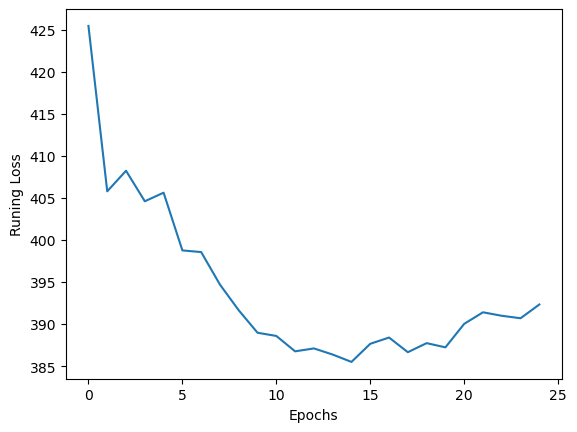

In [12]:
epoch_arr = np.arange(0, len(loss_arr))
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

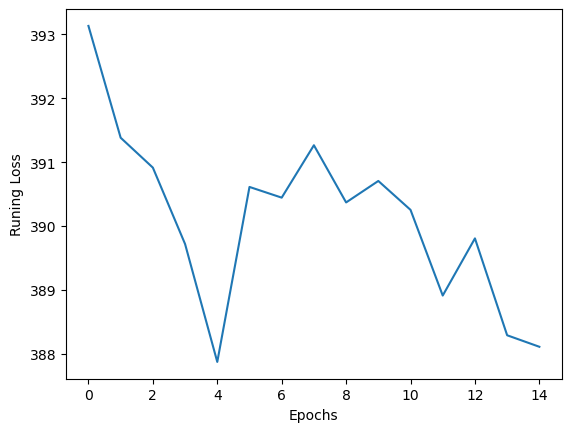

In [19]:
epoch_arr = np.arange(0, len(loss_arr))
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

In [13]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=5, bias=True)
  )
)

In [14]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_long_no_background_100206[0:128,:].astype(np.float32)))

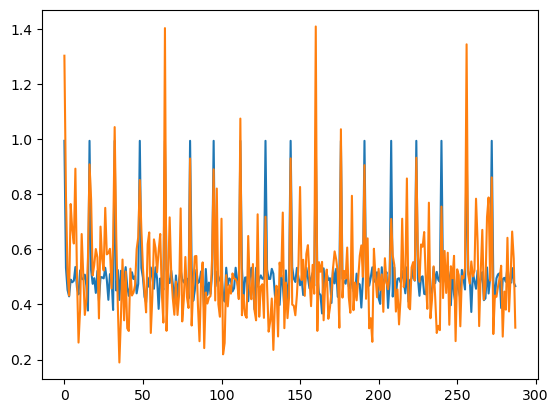

In [17]:
plt.plot(X_pred_train[0,:].detach().numpy())
plt.plot(normalized_scan_long_no_background_100206[0,:])